# Integrate GLEAN with AstraDB Serverless

> For more information, see the DataStax [Astra DB docs page.](#)

This notebook is a walkthough explaining how to use a AstraDB vector database collection as a source for Glean. Using the python `astrapy` client, we read from a collection and use the glean `indexingAPI` through a `Datasource`.

## 1. Prerequisites



### 1.1 Setup AstraDB

ℹ️ [Astra Reference documentation](https://docs.datastax.com/en/astra-db-serverless/databases/create-database.html)


`✅ 1.1.a`: Create an Astra ACCOUNT

Access [https://astra.datastax.com](https://astra.datastax.com) and register with `Google` or `Github` account.

![](https://github.com/datastaxdevs/mini-demo-astradb-glean/blob/main/images/01-login.png?raw=true)


`✅ 1.1.b`: Create an Astra Database

Get to the databases dashboard (by clicking on Databases in the left-hand navigation bar, expanding it if necessary), and click the `[Create Database]` button on the right.

![](https://github.com/datastaxdevs/mini-demo-astradb-glean/blob/main/images/02-create-db.png?raw=true)


- **ℹ️ Fields Description**

| Field                                      | Description                                                                                                                                                                                                                                   |
|--------------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Vector Database vs Serverless Database** | Choose `Vector Database` In june 2023, Cassandra introduced the support of vector search to enable Generative AI use cases.                                                                                                                   |
| **Database name**                          | It does not need to be unique, is not used to initialize a connection, and is only a label (keep it between 2 and 50 characters). It is recommended to have a database for each of your applications. The free tier is limited to 5 databases. |
| **Cloud Provider**                         | Choose whatever you like. Click a cloud provider logo, pick an Area in the list and finally pick a region. We recommend choosing a region that is closest to you to reduce latency. In free tier, there is very little difference.            |
| **Cloud Region**                           | Pick region close to you available for selected cloud provider and your plan.      

If all fields are filled properly, clicking the "Create Database" button will start the process.

![](https://github.com/datastaxdevs/mini-demo-astradb-glean/blob/main/images/03-pending-db.png?raw=true)


It should take a couple of minutes for your database to become `Active`.

![](https://github.com/datastaxdevs/mini-demo-astradb-glean/blob/main/images/04-active-db.png?raw=true)

`✅ 1.1.c`: Create an Astra TOKEN

To connect to your database, you need the API Endpoint and a token. The api endpoint is available on the database screen, there is a little icon to copy the URL in your clipboard. (it should look like `https://<db-id>-<db-region>.apps.astra.datastax.com`).

![](https://github.com/datastaxdevs/mini-demo-astradb-glean/blob/main/images/05-create-token-db.png?raw=true)

To get a token click the `[Generate Token]` button on the right. It will generate a token that you can copy to your clipboard.


### 1.2 Create a Token as Glean Admin

> [Glean Documentation](https://developers.glean.com/docs/indexing_api/indexing_api_tokens/)

Admins can manage these API tokens via the API tokens page within Workspace Settings

```
Workspace > Setup > API tokens > Indexing tokens tab
```

As a glean admin create a token and assign permissions.



### 1.3 Installation of dependencies

This command will install `astrapy` (astra python client) and all associated dependencies.

In [2]:
! pip install --quiet "astrapy==1.4.1" "datasets" "python-dotenv" "pandas==2.1.4"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.6/156.6 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.

### 1.4 Setup Variables

In [3]:
import os
from getpass import getpass
os.environ["ASTRA_DB_APPLICATION_TOKEN"] = getpass("ASTRA_DB_APPLICATION_TOKEN = ")
os.environ["ASTRA_DB_API_ENDPOINT"] = input("ASTRA_DB_API_ENDPOINT = ")

ASTRA_DB_APPLICATION_TOKEN = ··········
ASTRA_DB_API_ENDPOINT = https://e0ac686e-7942-4b25-832a-664ede8b1da0-us-east-2.apps.astra.datastax.com


## 3. Populate Data


### 3.1 Populate AstraDB collection

`✅ 3.1.a`: Connect to your Database (validating Credential)

In [4]:
import os
from astrapy import DataAPIClient
from astrapy.constants import VectorMetric
from astrapy.ids import UUID
from astrapy.exceptions import InsertManyException

# Initialize the client and get a "Database" object
client = DataAPIClient(os.environ["ASTRA_DB_APPLICATION_TOKEN"], caller_name="glean", caller_version="1.0")
database = client.get_database(os.environ["ASTRA_DB_API_ENDPOINT"])
print(f"* Credential are OK your database name is  {database.info().name}\n")

* Credential are OK your database name is  glean_datasource



`✅ 3.1.b`: Create a collection with Data to index (no vector needed)

In [5]:
from astrapy.info import CollectionVectorServiceOptions
from astrapy.constants import VectorMetric

customer_collab = database.create_collection("customer_collab",
   metric=VectorMetric.DOT_PRODUCT,
   dimension=1024,
   service=CollectionVectorServiceOptions(provider="nvidia", model_name="NV-Embed-QA"),
   check_exists=False,
);
print(f"* Collection 'customer_collab' is ready")

* Collection 'customer_collab' is ready


`✅ 3.1.c`: List and display collections of the Database

In [7]:
for coll_desc in database.list_collection_names(): print(coll_desc)

customer_collab
customer_support
plain_collection


`✅ 3.1.d`: Load a DataSet and show an entry

In [6]:
import pandas as pd
from datasets import load_dataset

support_tickets = load_dataset("datastax/glean-integration-demo")["train"]
print("An example entry:")
print(support_tickets[16]["_id"])
support_tickets_df = pd.DataFrame.from_dict(support_tickets)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

customer_support_tickets.csv:   0%|          | 0.00/3.95M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8469 [00:00<?, ? examples/s]

An example entry:
17


`✅ 3.1.e`: Import the DataSet

In [27]:
from ipywidgets import IntProgress
from IPython.display import display
import numpy as np

# Load to vector store
def load_to_astra(df, collection):
  len_df = len(df)
  f = IntProgress(min=0, max=len_df) # instantiate the bar
  display(f) # display the bar
  for i in range(len_df):
    f.value += 1
    f.description = str(f.value) + "/" + str(len_df)
    try:
      value = df.loc[i, "customer_age"]
      # add to the Astra DB Vector Database using insert_one statement
      collection.insert_one({
          "_id": i,
          "$vectorize": df.loc[i, "ticket_description"],
          "customer_name" : df.loc[i, "customer_name"],
          "customer_email" :  df.loc[i, "customer_email"],
          "customer_age" : int(value) if isinstance(value, np.int64) else value,
          "customer_gender" : df.loc[i, "customer_gender"],
          "product_purchased" : df.loc[i, "product_purchased"],
          "date_of_purchase" :  df.loc[i, "date_of_purchase"],
          "ticket_type" : df.loc[i, "ticket_type"],
          "ticket_subject" :  df.loc[i, "ticket_subject"],
          "ticket_description" :  df.loc[i, "ticket_description"],
          "ticket_status" :  df.loc[i, "ticket_status"],
          "resolution" : df.loc[i, "resolution"],
          "ticket_priority" :  df.loc[i, "ticket_priority"],
          "ticket_channel" :  df.loc[i, "ticket_channel"],
          "first_response_time" : df.loc[i, "first_response_time"],
          "time_to_resolution" :  df.loc[i, "time_to_resolution"],
          #"customer_rating" :  df.loc[i, "customer_rating"]
      })
    except Exception as error_info:
       print(f"An error occurred: {error_info}")

# This line is flushing the collection before inserting to avoid duplicated IDS
customer_collab.delete_many({})

# Look over the df and inserting items
load_to_astra(support_tickets_df, customer_collab)

IntProgress(value=0, max=8469)

You should get the data populate and visible in the Data Explorer in Astra Portal

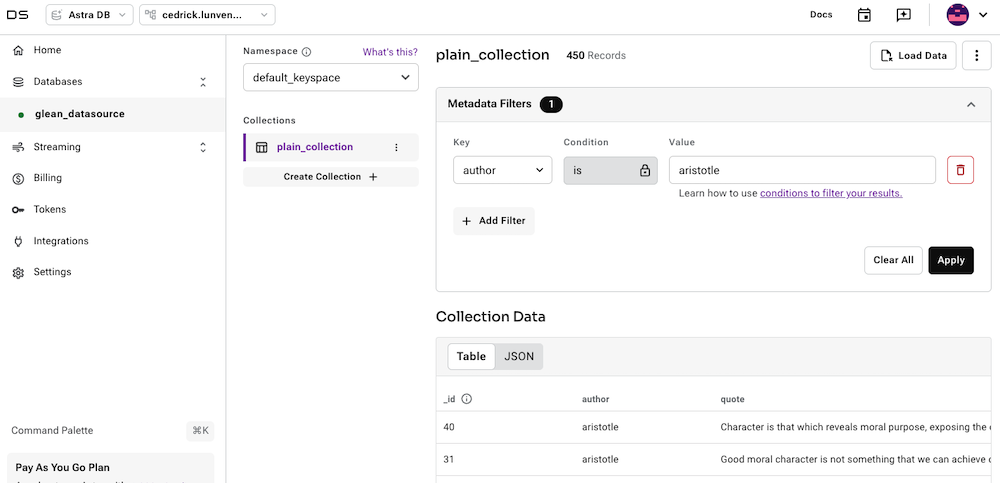



`✅ 3.1.f`: You can also list quotes here

In [7]:
doc_iterator = customer_collab.find({"customer_name": "Colin Ryan"})
for document in doc_iterator:
    print(document['product_purchased'])


### 3.2 Indexing the Data with Glean

`✅ 3.2.a`: Get your GLEAN TOKEN

- [Authentication](https://developers.glean.com/docs/indexing_api/indexing_api_getting_started/#authentication)


In [13]:
# Customer and DataSource
os.environ["GLEAN_CUSTOMER"] = input("GLEAN_CUSTOMER = ")
os.environ["GLEAN_DATASOURCE_NAME"] = input("GLEAN_DATASOURCE_NAME = ")

# Api Information
os.environ["GLEAN_API_USERNAME"] = input("GLEAN_API_USERNAME = ")
os.environ["GLEAN_API_TOKEN"] = getpass("GLEAN_API_TOKEN = ")
os.environ["GLEAN_API_ENDPOINT"] = "https://" + os.environ["GLEAN_CUSTOMER"] + "-be.glean.com/api/index/v1"
print("Api Setup, endpoint is: " + os.environ["GLEAN_API_ENDPOINT"])

GLEAN_CUSTOMER = datastax
GLEAN_DATASOURCE_NAME = astraDbCollectionDataSource
GLEAN_API_USERNAME = datastax
GLEAN_API_TOKEN = ··········
Api Setup, endpoint is: https://datastax-be.glean.com/api/index/v1


`✅ 3.2.b`: Install the Client

In [9]:
pip install https://app.glean.com/meta/indexing_api_client.zip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.3/732.3 kB 44.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for glean-indexing-api-client: filename=glean_indexing_api_client-1.0.0-py3-none-any.whl size=485130 sha256=f30cb39c225ad5fa082a81cc6817f0b92801a917b39bacdbe5bbd30e6b289d8a
  Stored in directory: /tmp/pip-ephem-wheel-cache-8moogaqe/wheels/fa/81/45/5d838523ec3203fbfea653c9505faa3bc6091748849d1cd6e8
Successfully built glean-indexing-api-client


`✅ 3.2.c`: Setup Glean Client

In [17]:
import glean_indexing_api_client as indexing_api

# Initializing the glean configuration
configuration = indexing_api.Configuration(host=os.environ["GLEAN_API_ENDPOINT"], access_token=os.environ["GLEAN_API_TOKEN"])

# Initializing the glean client
api_client = indexing_api.ApiClient(configuration)


`✅ 3.2.d`: Testing Glean Credentials


In [18]:
import json
from glean_indexing_api_client.api import datasources_api

# Listing datasource value
datasource_api = datasources_api.DatasourcesApi(api_client)
pretty_json = json.dumps(datasource_api.getdatasourceconfig_post_endpoint.params_map, indent=4)
print(pretty_json)

{
    "all": [
        "get_datasource_config_request",
        "async_req",
        "_host_index",
        "_preload_content",
        "_request_timeout",
        "_return_http_data_only",
        "_check_input_type",
        "_check_return_type",
        "_content_type",
        "_spec_property_naming",
        "_request_auths"
    ],
    "required": [
        "get_datasource_config_request"
    ],
    "nullable": [
        "_request_timeout"
    ],
    "enum": [],
    "validation": []
}


`✅ 3.2.e`: Setup a Datasource

> Glean Documentation:
> - [Setup a Datasource](https://developers.glean.com/docs/indexing_api/indexing_api_getting_started/#set-up-a-datasource)
> - [Add Datasource API Reference](https://developers.glean.com/indexing/tag/Datasources/paths/~1adddatasource/post/)

This operation can be done with the REST API or as a Custom Apps

In [29]:
import glean_indexing_api_client as indexing_api
from glean_indexing_api_client.api import datasources_api
from glean_indexing_api_client.model.custom_datasource_config import CustomDatasourceConfig
from glean_indexing_api_client.model.object_definition import ObjectDefinition

# config should be ok to get started.
datasource_config = CustomDatasourceConfig(
  name='astraDbCollectionDataSource',
  display_name='AstraDB Collection DataSource',
  datasource_category='PUBLISHED_CONTENT',
  url_regex='^https://e0ac686e-7942-4b25-832a-664ede8b1da0-us-east-2.apps.astra.datastax.com',
  object_definitions=[
            ObjectDefinition(
                doc_category='PUBLISHED_CONTENT',
                name='AstraVectorEntry'
              )
          ],
  # Permissions will be specified by email addresses instead of a
  # datasource-specific ID.
  #is_user_referenced_by_email=True,
)

try:
  datasource_api.adddatasource_post(datasource_config)
  print('DataSource has been created !')
except indexing_api.ApiException as e:
  print('Exception when calling DatasourcesApi->adddatasource_post: %s\\n' % e)

DataSource has been created !


`✅ 3.2.f`: Describe the DataSource


In [30]:
from glean_indexing_api_client.model.get_datasource_config_request import GetDatasourceConfigRequest

getDataSourceConfigRequest = GetDatasourceConfigRequest(
    datasource='astraDbCollectionDataSource'
)

datasource_config = datasource_api.getdatasourceconfig_post(getDataSourceConfigRequest);
print(datasource_config)

{'connector_type': 'PUSH_API',
 'datasource_category': 'PUBLISHED_CONTENT',
 'display_name': 'AstraDB Collection DataSource',
 'is_entity_datasource': False,
 'is_test_datasource': False,
 'is_user_referenced_by_email': True,
 'name': 'CUSTOM_ASTRADBCOLLECTIONDATASOURCE',
 'object_definitions': [{'doc_category': 'PUBLISHED_CONTENT',
                         'name': 'AstraVectorEntry'}],
 'strip_fragment_in_canonical_url': True,
 'trust_url_regex_for_view_activity': True,
 'url_regex': '^https://e0ac686e-7942-4b25-832a-664ede8b1da0-us-east-2.apps.astra.datastax.com'}


`✅ 3.2.g`: Index Collection in Glean


In [ ]:
import glean_indexing_api_client as indexing_api
from glean_indexing_api_client.api import documents_api
from glean_indexing_api_client.model.index_document_request import IndexDocumentRequest
from glean_indexing_api_client.model.document_definition import DocumentDefinition
from glean_indexing_api_client.model.custom_property import CustomProperty
from glean_indexing_api_client.model.content_definition import ContentDefinition
from glean_indexing_api_client.model.user_reference_definition import (
    UserReferenceDefinition,
)
from glean_indexing_api_client.model.document_permissions_definition import (
    DocumentPermissionsDefinition,
)

def index_astra_document_into_glean(astraDocument):
    # Perform mapping here
    document_id = str(astraDocument['_id'])
    title = astraDocument['ticket_subject']
    body_text = astraDocument['ticket_description']
    datasource_name = 'astraDbCollectionDataSource'

    # Create the request object
    request = IndexDocumentRequest(
        document=DocumentDefinition(
            datasource=datasource_name,
            #object_type="AstraVectorEntry",
            title=title,
            id=document_id,
            view_url="https://e0ac686e-7942-4b25-832a-664ede8b1da0-us-east-2.apps.astra.datastax.com",
            body=ContentDefinition(mime_type="text/plain", text_content=body_text),
            permissions=DocumentPermissionsDefinition(
                allow_anonymous_access=True
            ),
        )
        #,
        #customProperties = [
        #  CustomProperty(**{'quote': astraDocument.get('quote')}),
        #  CustomProperty(**{'philosopher': astraDocument.get('philosopher')})]
    )
    documents_api_client = documents_api.DocumentsApi(api_client)
    try:
        api = documents_api_client.indexdocument_post(request)
    except ApiException as e:
        print(f"Exception when calling DocumentsApi->indexdocument_post: {e}\n")


## INDEXING

for doc in customer_collab.find():
  index_astra_document_into_glean(doc)

